## Exploring genomes and mouse brain dataset

This notebook assumes you have already executed:

- the bash scripts for downloading human and mouse genomes
- the python script for preprocessing mouse brain dataset

These scripts are located at `data_preparation` directory and have prefix `download_` and `preprocess_`, respectively. Please see comments in these scripts for further instructions on running these scripts. 

In [36]:
import pdb 
import os
import random
import pickle
from itertools import chain


import os.path as osp
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# conda install -c conda-forge biopython
# pip install biopython
from Bio import SeqIO
from Bio import pairwise2

# conda install -c bioconda pyranges
# pip install pyranges
import pyranges as pr

# move working directory to parent
os.chdir("..")


#### Human (hg19 and hg38) and mouse (mm10) genome 

hg19 and hg38 are human genome assemblies. hg19 is short for GRCH37 (Genome Reference Consortium Human Build 37) and hg38 is short for GRCh38 (Genome Reference Consortium Human Build 38). hg38 is a corrected and improved version of hg19. Similarly, mm10 is one of the mouse genome assemblies. mm10 is short for GRCm38 (Genome Reference Consortium Mouse Build 38). 

In order to do an analysis based on genome sequence underlying ATAC-seq peaks, the most important step is to determine which version of the genome is used for aligning reads in an ATAC-seq experiment (mostly reported in Methods section of dataset papers). It is very important to distinguish between these builds since using one in place of other makes the analysis erroneous. In case of mouse brain dataset paper (Chromatin Potential Identified by Shared Single-Cell Profiling of RNA and Chromatin), mm10 and hg19 are used.

### Load genomes

In [2]:
def check_available(genome_type, chr_filenames):
    """ 
    This function checks if the files for the specified genome is
        ready for preprocessing
    :@param genome_type: One of "hg38", "hg19" or "mm10" 
    :@param chr_filenames: A list of file names for the chromosome that 
        should have been downloaded
    """
    data_path_prefix = f"./data/{genome_type}"
    assert osp.exists(data_path_prefix),\
        f"Please run download_{genome_type}.sh script first."

    for filename in chr_filenames:
        assert osp.exists(osp.join(data_path_prefix, filename)),\
            f"Please run download_{genome_type}.sh script first."

def load_genome_to_dict(genome_type, chr_filenames):
    """
    Load the specified genome to a dictionary where keys are chromosome
    names and values are genomic sequence for that chromosome
    :@param genome_type: One of "hg38", "hg19" or "mm10" 
    :@param chr_filenames: A list of file names for the chromosome that 
        should have been downloaded
    """

    check_available(genome_type, chr_filenames)

    data_path_prefix = f"./data/{genome_type}"
    chr_filenames = [osp.join(data_path_prefix, chrom)\
        for chrom in chr_filenames]

    # load fasta files per chromosome
    sequences = {}
    for filename in chr_filenames:
        file = open(filename)
        fasta = SeqIO.parse(file, "fasta")
        for record in fasta:
            name, sequence = record.id, str(record.seq)
            sequences[name] = sequence
        file.close()
    
    return sequences

Here, we will load genome sequences for all chromosomes other than chrM (mitochondrial DNA). This corresponds to 24 chromosomes for humans (chr1-22 + chrX + chrY) and 20 chromosomes for mouse (chr1-19 + chrX + chrY).

In [34]:
# humans: chr1-22 + chrX + chrY
chr_filenames = [f"chr{id}.fa"\
    for id in list(range(1,23)) + ["X", "Y"]]

# load hg19
genome_type = "hg19"
hg19_genome = load_genome_to_dict(genome_type, chr_filenames)

# load hg38
genome_type = "hg38"
hg38_genome = load_genome_to_dict(genome_type, chr_filenames)


Each genome assembly is a string from a 10 letter alphabet (ATGCN and atgcn). ATGC are bases and N denotes ambiguous base which indicates that corresponding genome locations could not be sequenced properly. Lowercase versions of these letters marks repeats and low-complexity regions of the genome. Please refer to [this](https://bioinformatics.stackexchange.com/questions/225/uppercase-vs-lowercase-letters-in-reference-genome) source for complete definition of this alphabet.

For our use case, we will treat lowercase letters and uppercase letters in same manner. ATGC will be 1-hot encoded (i.e. 4 $\times$ 1 vector). Similarly, N will be encoded as a 4 $\times$ 1 vector whose all elements are $0.25$ to reflect ambiguity.

Loaded genomes are preprocessed to be a dict with chromosome names as keys and genome sequence of that chromosomes as values.

#### Compare hg19 and hg38 chromosome by chromosome

Unique characters in hg38 genome: ['G', 'a', 'N', 'T', 'A', 'g', 'c', 'C', 't', 'n']
Unique characters in hg19 genome: ['G', 'a', 'N', 'T', 'A', 'g', 'c', 'C', 't', 'n']


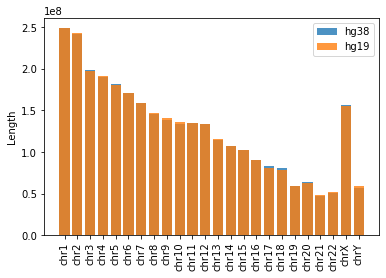

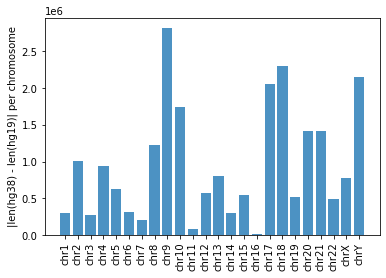

In [38]:
chr_names = [name.split(".")[0] for name in chr_filenames]

# find alphabet of the genome
temp = [list(set(hg38_genome[chrom])) for chrom in chr_names]
alph = list(set(chain(*temp)))
print(f"Unique characters in hg38 genome: {alph}")

temp = [list(set(hg19_genome[chrom])) for chrom in chr_names]
alph = list(set(chain(*temp)))
print(f"Unique characters in hg19 genome: {alph}")

# calculate chromosome lengths
df_dct = {
    "hg38": [len(hg38_genome[chrom]) for chrom in chr_names],
    "hg19": [len(hg19_genome[chrom]) for chrom in chr_names]
}
df = pd.DataFrame(df_dct, index=chr_names)

# plot absolute lengths
plt.figure()
ax = plt.gca()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel("Length")
xtick_location = range(1, df.shape[0]+1)
ax.bar(xtick_location, df["hg38"], label="hg38", alpha=0.8)
ax.bar(xtick_location, df["hg19"], label="hg19", alpha=0.8)
ax.set_xticks(xtick_location)
ax.set_xticklabels(chr_names)
ax.legend()
plt.xticks(rotation=90)
plt.show()

# plot length difference
plt.figure()
ax = plt.gca()
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel("|len(hg38) - len(hg19)| per chromosome")
xtick_location = range(1, df.shape[0]+1)
ax.bar(xtick_location, (df["hg38"] - df["hg19"]).abs(), alpha=0.8)
ax.set_xticks(xtick_location)
ax.set_xticklabels(chr_names)
plt.xticks(rotation=90)
plt.show()



Now, we delete human genomes since they are not needed and load mouse genome in the same format as in human genome.

In [ ]:
del hg38_genome, hg19_genome

In [3]:
# mouse: chr1-19 + chrX + chrY
chr_filenames = [f"chr{id}.fa" for id in list(range(1,20)) + ["X", "Y"]]

# load mm10
genome_type = "mm10"
mm10_genome = load_genome_to_dict(genome_type, chr_filenames)

### Exploring genome sequences underlying peaks
Please run the "preprocess_mouse_brain_data.py" script. For this dataset all peaks have 500bp length. However, for each dataset length of peaks may differ. 

- load mouse brain dataset preprocessed to include genomic regions of peaks
- (Optional) plot the distribution of peak lengths as a histogram
- (Optional) expand peaks to the 1344bp (for full scale scBasset)
- expand peaks by 30 bp at each side. This is to be used for random shifting data augmentation procedure for scBasset model.
- 1-hot encode sequences
- attach genome sequences to var field of AnnData object for ATAC modality.


In [26]:
def dna_1hot(seq, seq_len=None, n_uniform=False):
    """dna_1hot
    Args:
      seq:       nucleotide sequence.
      seq_len:   length to extend/trim sequences to.
      n_uniform: represent N's as 0.25, forcing float16,
                 rather than sampling.
    Returns:
      seq_code: length by nucleotides array representation.
    """
    if seq_len is None:
        seq_len = len(seq)
        seq_start = 0
    else:
        if seq_len <= len(seq):
            # trim the sequence
            seq_trim = (len(seq) - seq_len) // 2
            seq = seq[seq_trim : seq_trim + seq_len]
            seq_start = 0
        else:
            seq_start = (seq_len - len(seq)) // 2
    seq = seq.upper()

    # map nt's to a matrix len(seq)x4 of 0's and 1's.
    if n_uniform:
        seq_code = np.zeros((seq_len, 4), dtype="float16")
    else:
        seq_code = np.zeros((seq_len, 4), dtype="bool")

    for i in range(seq_len):
        if i >= seq_start and i - seq_start < len(seq):
            nt = seq[i - seq_start]
            if nt == "A" or nt == "a":
                seq_code[i, 0] = 1
            elif nt == "C" or nt == "c":
                seq_code[i, 1] = 1
            elif nt == "G" or nt == "g":
                seq_code[i, 2] = 1
            elif nt == "T" or nt == "t":
                seq_code[i, 3] = 1
            else:
                if n_uniform:
                    seq_code[i, :] = 0.25
                else:
                    ni = random.randint(0, 3)
                    seq_code[i, ni] = 1
    return seq_code

In [32]:
import anndata as ad

# load preprocessed atac data of mouse brain dataset
data_path_prefix = f"./data/mouse_brain"
adata = ad.read_h5ad(osp.join(data_path_prefix, "atac_count.preprocessed.h5ad"))
peaks = adata.var

# calculate length of peaks (all peaks are 500 bp)
peaks["length"] = peaks["end"] - peaks["start"] + 1
assert peaks["length"].mean() == 500 and peaks["length"].std() == 0

# extend peaks 30bp both upstream downstream
# during training we will stochastically shift sequences by 
# stochastically removing 30bp from sequence start, end or both
offset = 30
peaks["sequence"] = [mm10_genome[chrom][start-offset:end+offset+1]\
    for chrom, start, end in zip(peaks["chr"], peaks["start"], peaks["end"])]
temp = [len(seq) for seq in peaks["sequence"]]
assert np.mean(temp) == 500 + 2 * offset and np.std(temp) == 0

# one hot encode sequences
peaks["sequence"] = [np.array(dna_1hot(seq, n_uniform=True)) for seq in peaks["sequence"]]
assert peaks["sequence"][0].shape == (560, 4)

# add dataframe back to var field of AnnData object for ATAC data and save
adata.var = peaks

# save
filename = osp.join(data_path_prefix,\
    "atac_count.seq.h5ad")
adata.write(filename)